# Brain Tumor Classification
### Deep Learning - April 2022

Beatriz Vizoso m20210666

Filipa Alves m20210662

Helena Oliveira r20181121

Maria Almeida m20210611

In [58]:
import os, random
from os import path
from numpy.random import seed
import keras
import keras as K
from keras import layers,models


from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img, array_to_img, img_to_array


from keras.applications.vgg16 import VGG16
from keras.applications.densenet import DenseNet121


from keras.callbacks import Callback, CSVLogger

from keras.models import load_model
from keras.utils.vis_utils import plot_model
from keras import backend as K

from keras.models import Model
from keras.layers import Input, Dense, Dropout, BatchNormalization, Flatten, Activation, GlobalAveragePooling2D,Conv2D, MaxPooling2D

from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import numpy as np
import pandas as pd
import math
import cv2
import time

from distutils.dir_util import copy_tree
import shutil
from PIL import Image
import seaborn as sns
from tqdm import tqdm

from tensorflow import random as tfrandom
import tensorflow as tf

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import ParameterGrid

#pip install pydot-ng 

# to assure reproducibility
random.seed(42)
tf.random.set_seed(42)

In [59]:
base_path=os.getcwd()

In [60]:
base_path

'c:\\Users\\Utilizador\\Desktop\\2_semestre_DS\\Deep_Learning\\DL_GroupProject\\DeepLearning_Group_Project'

In [61]:
dir_path=(base_path+r"\tumor_data")

In [162]:
# rename the images to 1_xx, 2_xx, 3_xx, by the labels 

for _, label in enumerate(os.listdir(dir_path)):
    folder_label = os.path.join(dir_path, label)
 
    counts=0
    for _, image in enumerate(os.listdir(folder_label)):
        
        dst=image
    
        if '_' in dst:
            continue
        else:
            dst = str(label) + "_" + str(counts) + ".png"
            src = os.path.join(folder_label, image)
            dst = os.path.join(folder_label, dst)
            print(counts)
            os.rename(src, dst)
            
        counts=counts+1
        

In [5]:
# define directories for the train, val and test splits
train_path = os.path.join(dir_path, 'train')
val_path = os.path.join(dir_path, 'validation')
test_path = os.path.join(dir_path, 'test')

In [164]:
def createdir(mydir):
    try:
        os.mkdir(mydir)
    except OSError:
        pass

# create the directories

createdir(train_path)
createdir(val_path)
createdir(test_path)

In [165]:
# create the directories for each label for each train, validation and test folders

count=0
for dir in [train_path, val_path, test_path]:
    count+=1
    for label in ['1','2','3']:
        if count == 1:
            createdir(os.path.join(dir,str("train_{0}".format(str(label)))))
        elif count == 2:
            createdir(os.path.join(dir,str("val_{0}".format(str(label)))))   
        elif count == 3:
            createdir(os.path.join(dir,str("test_{0}".format(str(label)))))

In [166]:
# proportion we want for train, val_test and the test datasets
prop_train=0.80
prop_val_test=0.20
prop_test=0.50 # 50% of the 20% in val_test

In [167]:
labels={'label1':708,'label2':1426,'label3':930}

In [168]:
labels['label1']=round(labels['label1']*prop_val_test)
labels['label2']=round(labels['label2']*prop_val_test)
labels['label3']=round(labels['label3']*prop_val_test)
labels

{'label1': 142, 'label2': 285, 'label3': 186}

In [ ]:
image_info = {'width': [], 'height': []}
for path in [dir_path+r'\1', dir_path+r'\2', dir_path+r'\3']:
    # for index, letter in enumerate(os.listdir(train_dir)):
    #     folder_letter = os.path.join(train_dir, letter)
    #     file_list = [x for x in os.listdir(folder_letter)]
    
    for _, image in enumerate(os.listdir(path)):      
    # opening the image file and getting size info
        print(image)
        img_path = os.path.join(path, image)
        
        print(img_path)
        img = Image.open(img_path)
        width, height = img.size
        # adding size parameters and filenames to the dictionary
        #image_info['filename'].append(img_filename)
        image_info['width'].append(width)
        image_info['height'].append(height)

# creating a dataframe with the image's sizes
img_df = pd.DataFrame(data=image_info)
# img_df['area'] = img_df['height'] * img_df['width']
# img_df['aspect_ratio'] = img_df['width'] / img_df['height']

In [ ]:
# there are 15 images 256*256 pixels
print(len(img_df[(img_df['width']==256) & (img_df['height']==256)]))#.describe().T

print(img_df.describe().T)

# ALL IMAGES ARE SQUARED
print(len(img_df[img_df['width'] != img_df['height']]))


15
         count        mean      std    min    25%    50%    75%    max
width   3064.0  510.746736  17.8709  256.0  512.0  512.0  512.0  512.0
height  3064.0  510.746736  17.8709  256.0  512.0  512.0  512.0  512.0
0


In [62]:
train_datagen_aug=ImageDataGenerator(
                    rescale=1./255,
                    #rotation_range=50,
                    rotation_range=10,
                    shear_range=0.05)
                    #horizontal_flip=True )

train_generator_aug = train_datagen_aug.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical',
    color_mode='grayscale',
    seed=42
)

Found 2451 images belonging to 3 classes.


In [63]:
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical',
    color_mode='grayscale',
    seed=42
)

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(150, 150),  
    batch_size=20,
    class_mode='categorical',
    color_mode='grayscale',
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(150, 150), 
    batch_size=20,
    class_mode='categorical',
    color_mode='grayscale',
    seed=42,
    shuffle=False
)

Found 2451 images belonging to 3 classes.
Found 307 images belonging to 3 classes.
Found 306 images belonging to 3 classes.


In [64]:
train_generator_rgb = train_datagen.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical',
    color_mode='rgb',
    seed=42
)

val_generator_rgb = val_datagen.flow_from_directory(
    val_path,
    target_size=(150, 150),  
    batch_size=20,
    class_mode='categorical',
    color_mode='rgb',
    seed=42
)

Found 2451 images belonging to 3 classes.
Found 307 images belonging to 3 classes.


In [65]:
class_dict = {0: 'meningioma_tumor',
              1: 'glioma_tumor',
              2: 'pituitary_tumor'}

In [66]:
# ADAPTED FROM https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [67]:
# ADAPTED FROM https://stackoverflow.com/questions/43178668/record-the-computation-time-for-each-epoch-in-keras-during-model-fit 
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

time_callback = TimeHistory()

In [68]:
# FUNCTION TO SAVE THE TIME TAKEN BY EACH EPOCH OF A MODEL, IN A CSV FORMAT

def save_times(model, times, name_model):
  
    times_info = {'Model': ['Model {}'.format(str(name_model))]}
    for idx, time in enumerate(times):
        times_info[idx] = times[idx]
    df_times = pd.DataFrame(times_info)

    if os.path.exists(r'.\models\models_times.csv'):
        df_times.to_csv(r'.\models\models_times.csv', mode='a', header=False, index=False)
    else:
        df_times.to_csv(r'.\models\models_times.csv')

In [69]:
# FUNCTION TO PLOT F1 AND LOSS
def plot_history(his, patience, model_name):
   
    f1 = his['f1_m']
    f1_val=his['val_f1_m']
    loss = his['loss']
    loss_val=his['val_loss']

    epochs=range(1,len(f1)+1)

    plt.rcParams["figure.dpi"] = 100
    plt.plot(epochs, f1,'bo',label='Training F1')
    plt.plot(epochs, f1_val,'b',label='Validation F1')
    plt.axvline(x=len(f1)-patience,color='gray',linestyle='--',label='Model saved')
    plt.title(f'{model_name} - Training and Validation F1 score', pad=15)
    plt.xlabel('Number of Epochs')
    plt.ylabel('F1 score')
    plt.legend()
    plt.figure()

    plt.rcParams["figure.dpi"] = 100
    plt.plot(epochs, loss,'bo',label='Training Loss')
    plt.plot(epochs, loss_val,'b',label='Validation Loss')
    plt.axvline(x=len(f1)-patience,color='gray',linestyle='--',label='Best Loss value')
    plt.title(f'{model_name} - Training and Validation Loss', pad=15)
    plt.xlabel('Number of Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.figure()

In [70]:
# FUNCTION TO DEFINE THE CALLBACKS

def callback(filename):
  callname_list=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=4),
                keras.callbacks.ModelCheckpoint(filepath=os.path.join(base_path+ "\models")+filename, monitor='val_loss',mode='min',verbose=1, save_best_only=True)
                ,time_callback]

  return callname_list


In [71]:
# TO OVERCOME THE PROBLEM RISEN BY AN UNKNOWN METRIC, WHEN LOADING A MODEL ALREADY SAVED
dependencies = {
    'f1_m': f1_m
}

In [16]:
# UNDERSTANDING HOW 'STEPS_PER_EPOCH' AND 'VAL_STEPS' ARE DEFINED
BATCH_SIZE=20 
TRAINING_SIZE = 2451 
VALIDATION_SIZE = 307 

compute_steps_per_epoch = lambda x: int(math.ceil(1. * x / BATCH_SIZE)) 
steps_per_epoch = compute_steps_per_epoch(TRAINING_SIZE) 
val_steps = compute_steps_per_epoch(VALIDATION_SIZE) 

print(steps_per_epoch)
print(val_steps)

123
16


# MODELS

## First random model

In [72]:
callbacks_BW = callback("\modelBW.h5")

In [73]:
model = models.Sequential()

model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Flatten())
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1_m])

history_1st = model.fit_generator(train_generator, callbacks=callbacks_BW, epochs=30, steps_per_epoch=123, validation_steps=16,
                                 validation_data=val_generator, workers=2)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
123/123 [==============================] - ETA: 0s - loss: 0.7933 - f1_m: 0.5451
Epoch 00001: val_loss improved from inf to 0.65194, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\modelBW.h5
123/123 [==============================] - 154s 1s/step - loss: 0.7933 - f1_m: 0.5451 - val_loss: 0.6519 - val_f1_m: 0.7021
Epoch 2/30
123/123 [==============================] - ETA: 0s - loss: 0.5962 - f1_m: 0.7230
Epoch 00002: val_loss improved from 0.65194 to 0.58672, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\modelBW.h5
123/123 [==============================] - 134s 1s/step - loss: 0.5962 - f1_m: 0.7230 - val_loss: 0.5867 - val_f1_m: 0.7238
Epoch 3/30
123/123 [==============================] - ETA: 0s - loss: 0.4633 - f1_m: 0.7916
Epoch 00003: val_loss impr

In [ ]:
#np.save('models/historyBW.npy',history_1st.history)
modelBW = keras.models.load_model('models/modelBW.h5', custom_objects=dependencies)
historyBW=np.load('models/historyBW.npy',allow_pickle='TRUE').item()
#timesBW = time_callback.times
#save_times(modelBW, timesBW,'modelBW')

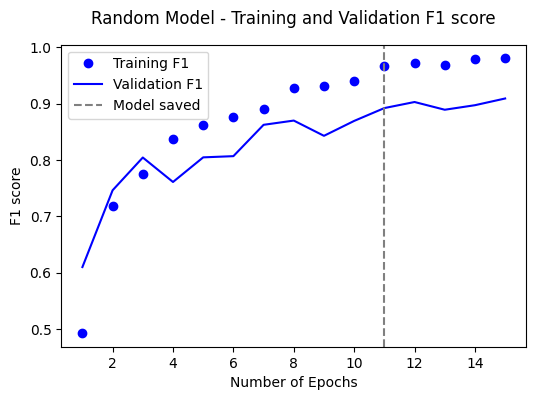

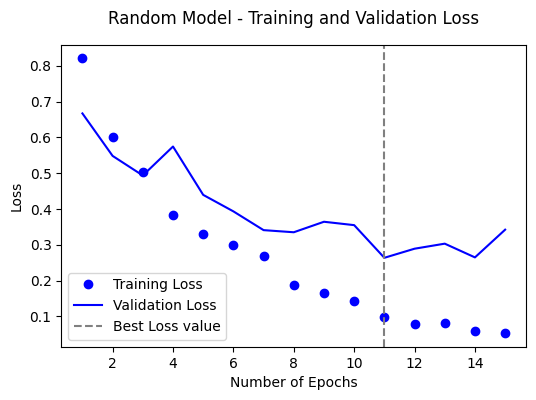

<Figure size 600x400 with 0 Axes>

In [ ]:
plot_history(historyBW,4,'Random Model')

## Increasing the number of filters through CNN

In [ ]:
callbacks_BW_inc = callback("\modelBW_inc.h5")
#increase the nr of filters through the CNN

In [ ]:
model2 = models.Sequential()

model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model2.add(layers.MaxPooling2D(2, 2))
model2.add(layers.Conv2D(32, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D(2, 2))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D(2, 2))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D(2, 2))
model2.add(layers.Flatten())
model2.add(layers.Dense(100, activation='relu'))
model2.add(layers.Dense(3, activation='softmax'))

model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1_m])

history_2 = model2.fit_generator(train_generator, callbacks=callbacks_BW_inc, epochs=30, steps_per_epoch=123, validation_steps=16,
                                 validation_data=val_generator, workers=2)

Epoch 1/30
123/123 [==============================] - ETA: 0s - loss: 0.7821 - f1_m: 0.5629
Epoch 00001: val_loss improved from inf to 0.64189, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\modelBW_inc.h5
123/123 [==============================] - 66s 536ms/step - loss: 0.7821 - f1_m: 0.5629 - val_loss: 0.6419 - val_f1_m: 0.7159
Epoch 2/30
123/123 [==============================] - ETA: 0s - loss: 0.5613 - f1_m: 0.7450
Epoch 00002: val_loss improved from 0.64189 to 0.49001, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\modelBW_inc.h5
123/123 [==============================] - 72s 581ms/step - loss: 0.5613 - f1_m: 0.7450 - val_loss: 0.4900 - val_f1_m: 0.7882
Epoch 3/30
123/123 [==============================] - ETA: 0s - loss: 0.4478 - f1_m: 0.8084
Epoch 00003: val_loss did not improve from 0.49001
123/123 [==============================

In [ ]:
#np.save('models/historyBW_inc.npy',history_2.history)
modelBW_inc = keras.models.load_model('models/modelBW_inc.h5', custom_objects=dependencies)
historyBW_inc=np.load('models/historyBW_inc.npy',allow_pickle='TRUE').item()
#timesBW = time_callback.times
#save_times(modelBW_inc, timesBW,'modelBW_inc')

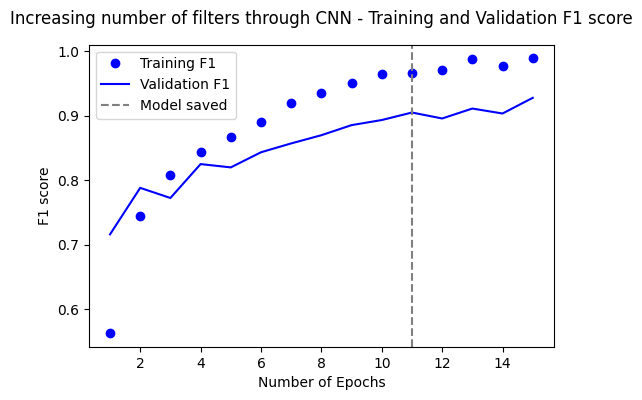

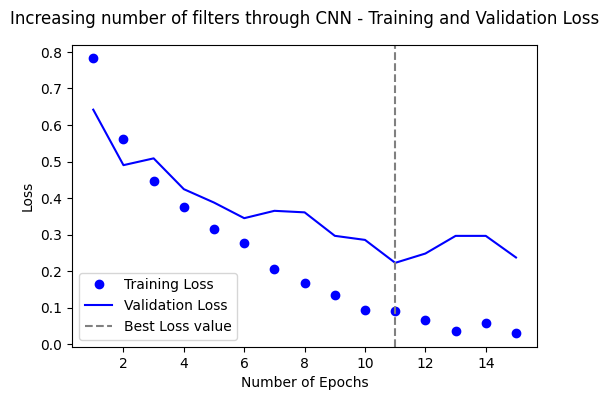

<Figure size 600x400 with 0 Axes>

In [ ]:
plot_history(historyBW_inc,4,'Increasing number of filters through CNN')

## Reducing the number of layers to overcome overfitting

In [ ]:
callbacks_BW_simple = callback("\modelBW_simple.h5")
#increase the nr of filters through the CNN

In [ ]:
model3 = models.Sequential()

model3.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model3.add(layers.MaxPooling2D(2, 2))
model3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D(2, 2))
model3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D(2, 2))
model3.add(layers.Flatten())
model3.add(layers.Dense(100, activation='relu'))
model3.add(layers.Dense(3, activation='softmax'))

model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1_m])

history_3 = model3.fit_generator(train_generator, callbacks=callbacks_BW_simple, epochs=30, steps_per_epoch=123, validation_steps=16,
                                 validation_data=val_generator, workers=2)

Epoch 1/30
123/123 [==============================] - ETA: 0s - loss: 0.7221 - f1_m: 0.6164
Epoch 00001: val_loss improved from inf to 0.68303, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\modelBW_simple.h5
123/123 [==============================] - 81s 657ms/step - loss: 0.7221 - f1_m: 0.6164 - val_loss: 0.6830 - val_f1_m: 0.6612
Epoch 2/30
123/123 [==============================] - ETA: 0s - loss: 0.5392 - f1_m: 0.7424
Epoch 00002: val_loss improved from 0.68303 to 0.53808, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\modelBW_simple.h5
123/123 [==============================] - 77s 623ms/step - loss: 0.5392 - f1_m: 0.7424 - val_loss: 0.5381 - val_f1_m: 0.7250
Epoch 3/30
123/123 [==============================] - ETA: 0s - loss: 0.4233 - f1_m: 0.8077
Epoch 00003: val_loss improved from 0.53808 to 0.52782, saving model to c:\Users\Uti

In [ ]:
#np.save('models/historyBW_simple.npy',history_3.history)
modelBW_simple = keras.models.load_model('models/modelBW_simple.h5', custom_objects=dependencies)
historyBW_simple=np.load('models/historyBW_simple.npy',allow_pickle='TRUE').item()
#timesBW_simple = time_callback.times
#save_times(modelBW_simple, timesBW_simple,'modelBW_simple')

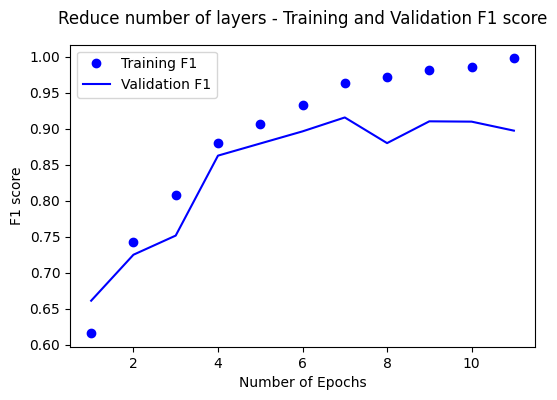

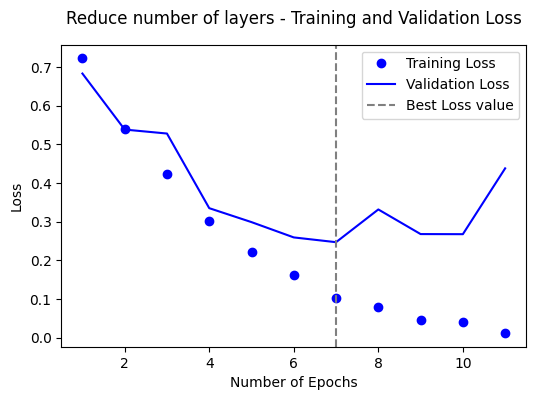

<Figure size 600x400 with 0 Axes>

In [ ]:
plot_history(historyBW_simple,4,'Reduce number of layers')

## Introducing data augmentation, drop out of 0.5, reduce patience on EarlyStopping and ReduceLROnPlateau callback to overcome overfitting

In [ ]:
def callback(filename):
      callname_list=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
            keras.callbacks.ModelCheckpoint(filepath=os.path.join(base_path+ "\models")+filename, monitor='val_loss',mode='min',verbose=1, save_best_only=True),
            time_callback, 
            keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, mode='min', min_lr=1e-4)]

      return callname_list

In [ ]:
def create_model_drop(input_drop,callbacks_input):
    model = models.Sequential()

    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
    model.add(layers.MaxPooling2D(2, 2))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(2, 2))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(2, 2))
    model.add(layers.Flatten())
    model.add(layers.Dropout(input_drop))
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(3, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1_m])

    history = model.fit_generator(train_generator_aug, callbacks=callbacks_input, epochs=30, steps_per_epoch=123, validation_steps=16,
                                    validation_data=val_generator, workers=2)
    return history

In [ ]:
callbacks_BW_aug_5 = callback("\modelBW_aug_5.h5")

In [ ]:
history_4=create_model_drop(0.5,callbacks_BW_aug_5)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
123/123 [==============================] - ETA: 0s - loss: 0.7707 - f1_m: 0.5844
Epoch 00001: val_loss improved from inf to 0.60630, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\modelBW_aug_5.h5
123/123 [==============================] - 85s 688ms/step - loss: 0.7707 - f1_m: 0.5844 - val_loss: 0.6063 - val_f1_m: 0.7426
Epoch 2/30
123/123 [==============================] - ETA: 0s - loss: 0.5832 - f1_m: 0.7324
Epoch 00002: val_loss improved from 0.60630 to 0.49565, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\modelBW_aug_5.h5
123/123 [==============================] - 85s 688ms/step - loss: 0.5832 - f1_m: 0.7324 - val_loss: 0.4957 - val_f1_m: 0.7823
Epoch 3/30
123/123 [==============================] - ETA: 0s - loss: 0.4590 - f1_m: 0.7996
Epoch 0000

In [ ]:
#np.save('models/historyBW_aug_5.npy',history_4.history)
modelBW_aug_5 = keras.models.load_model('models/modelBW_aug_5.h5', custom_objects=dependencies)
historyBW_aug_5=np.load('models/historyBW_aug_5.npy',allow_pickle='TRUE').item()
#timesBW_aug_5 = time_callback.times
#save_times(modelBW_aug_5, timesBW_aug_5,'modelBW_aug_5')

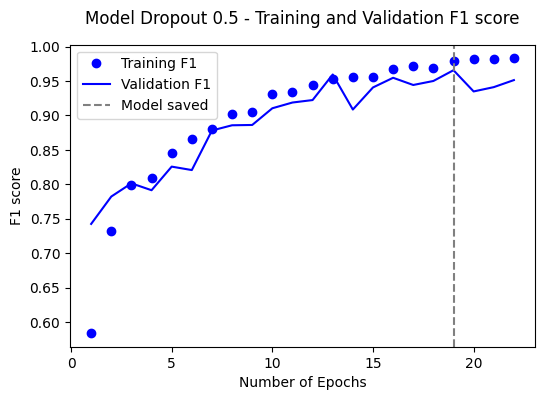

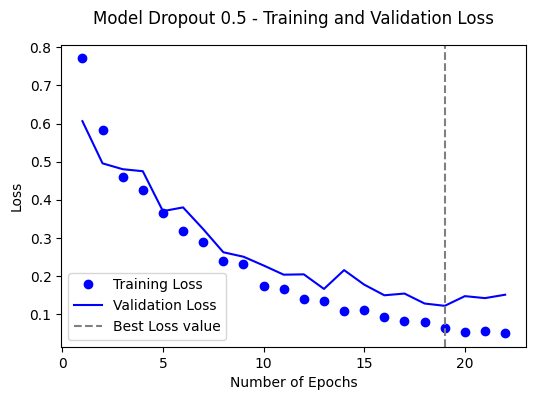

<Figure size 600x400 with 0 Axes>

In [ ]:
plot_history(historyBW_aug_5,3,'Model Dropout 0.5')

## Changing drop out to 0.3

In [ ]:
callbacks_BW_aug_3 = callback("\modelBW_aug_3.h5")

In [ ]:
history_5=create_model_drop(0.3,callbacks_BW_aug_3)

Epoch 1/30
123/123 [==============================] - ETA: 0s - loss: 0.7330 - f1_m: 0.6117
Epoch 00001: val_loss improved from inf to 0.66092, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\modelBW_aug_3.h5
123/123 [==============================] - 73s 592ms/step - loss: 0.7330 - f1_m: 0.6117 - val_loss: 0.6609 - val_f1_m: 0.6600
Epoch 2/30
123/123 [==============================] - ETA: 0s - loss: 0.5207 - f1_m: 0.7690
Epoch 00002: val_loss improved from 0.66092 to 0.46974, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\modelBW_aug_3.h5
123/123 [==============================] - 80s 649ms/step - loss: 0.5207 - f1_m: 0.7690 - val_loss: 0.4697 - val_f1_m: 0.8069
Epoch 3/30
123/123 [==============================] - ETA: 0s - loss: 0.4352 - f1_m: 0.8097
Epoch 00003: val_loss improved from 0.46974 to 0.44493, saving model to c:\Users\Utili

In [ ]:
#np.save('models/historyBW_aug_3.npy',history_5.history)
modelBW_aug_3 = keras.models.load_model('models/modelBW_aug_3.h5', custom_objects=dependencies)
historyBW_aug_3=np.load('models/historyBW_aug_3.npy',allow_pickle='TRUE').item()
#timesBW_aug_3 = time_callback.times
#save_times(modelBW_aug_3, timesBW_aug_3,'modelBW_aug_3')

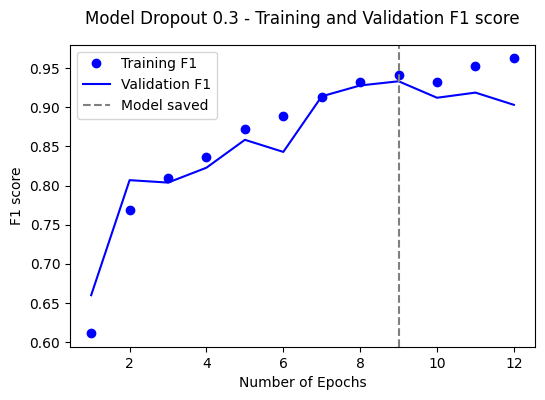

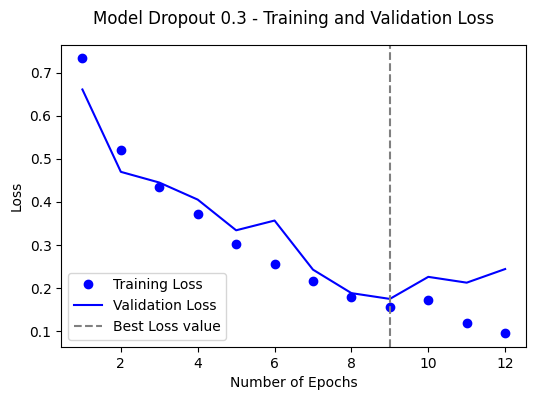

<Figure size 600x400 with 0 Axes>

In [ ]:
plot_history(historyBW_aug_3,3,'Model Dropout 0.3')

## Changing drop out to 0.4 

In [ ]:
callbacks_BW_aug_4 = callback("\modelBW_aug_4.h5")

In [ ]:
history_6=create_model_drop(0.4,callbacks_BW_aug_4)

Epoch 1/30
123/123 [==============================] - ETA: 0s - loss: 0.7503 - f1_m: 0.6051
Epoch 00001: val_loss improved from inf to 0.69886, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\modelBW_aug_4.h5
123/123 [==============================] - 86s 702ms/step - loss: 0.7503 - f1_m: 0.6051 - val_loss: 0.6989 - val_f1_m: 0.7055
Epoch 2/30
123/123 [==============================] - ETA: 0s - loss: 0.5600 - f1_m: 0.7487
Epoch 00002: val_loss improved from 0.69886 to 0.54631, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\modelBW_aug_4.h5
123/123 [==============================] - 84s 684ms/step - loss: 0.5600 - f1_m: 0.7487 - val_loss: 0.5463 - val_f1_m: 0.7568
Epoch 3/30
123/123 [==============================] - ETA: 0s - loss: 0.4462 - f1_m: 0.8076
Epoch 00003: val_loss improved from 0.54631 to 0.50075, saving model to c:\Users\Utili

In [17]:
#np.save('models/historyBW_aug_4.npy',history_6.history)
modelBW_aug_4 = keras.models.load_model('models/modelBW_aug_4.h5', custom_objects=dependencies)
historyBW_aug_4=np.load('models/historyBW_aug_4.npy',allow_pickle='TRUE').item()
#timesBW_aug_4 = time_callback.times
#save_times(modelBW_aug_4, timesBW_aug_4,'modelBW_aug_4')

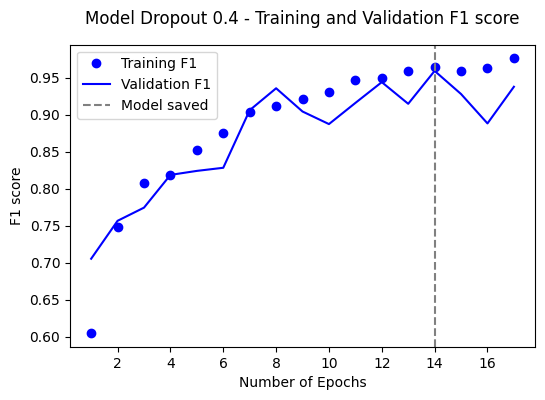

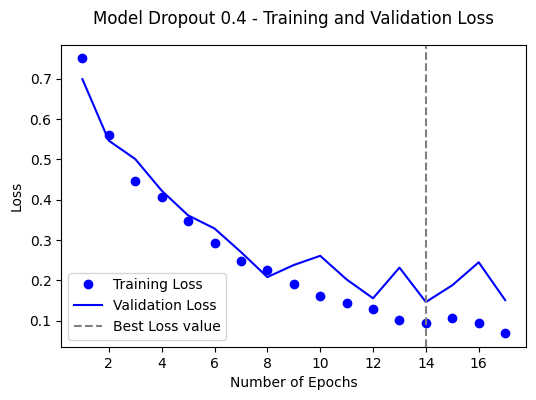

<Figure size 600x400 with 0 Axes>

In [18]:
plot_history(historyBW_aug_4,3,'Model Dropout 0.4')

In [ ]:
preds = modelBW_aug_4.predict(test_generator)
predicted_class_indices = np.argmax(preds, axis=1)
test_labels = test_generator.labels

cm = confusion_matrix(test_labels, predicted_class_indices)
test_score = modelBW_aug_4.evaluate_generator(test_generator)
cm

array([[ 65,   5,   1],
       [  5, 135,   2],
       [  1,   0,  92]], dtype=int64)

In [ ]:
print(f'Test loss: {test_score[0]} / Test f1score: {test_score[1]}')

Test loss: 0.17702293395996094 / Test accuracy: 0.9489582777023315


In [ ]:
print(classification_report(test_generator.labels, predicted_class_indices))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92        71
           1       0.96      0.95      0.96       142
           2       0.97      0.99      0.98        93

    accuracy                           0.95       306
   macro avg       0.95      0.95      0.95       306
weighted avg       0.95      0.95      0.95       306



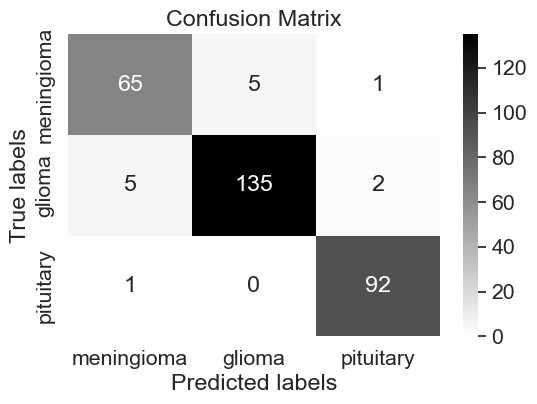

In [ ]:
categories = ['meningioma', 'glioma','pituitary']

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax,cmap='binary')

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(categories)
ax.yaxis.set_ticklabels(categories)

plt.show()

In [ ]:
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz/bin/'

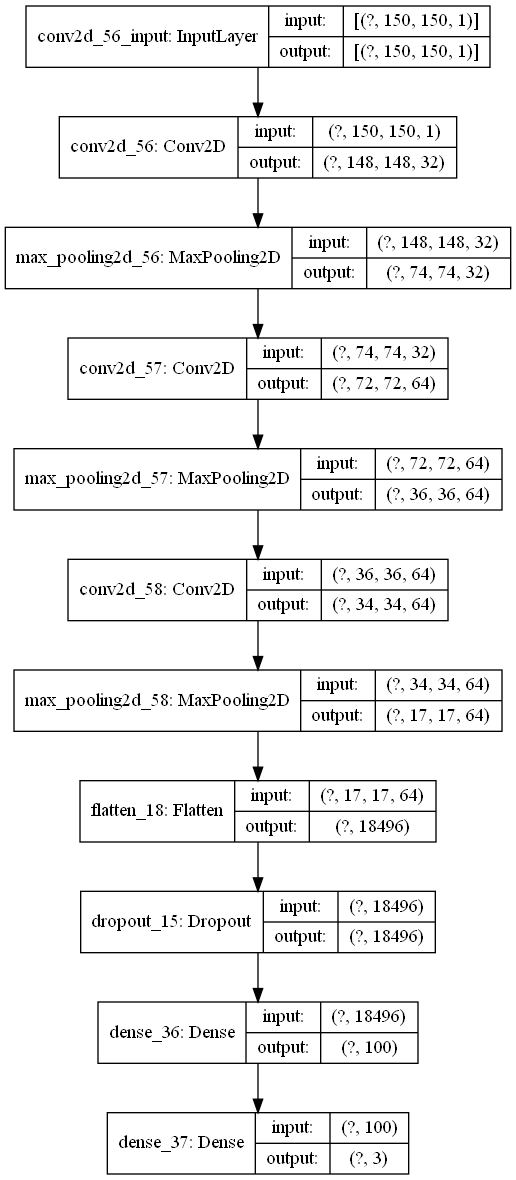

In [ ]:
plot_model(modelBW_aug_4, to_file = 'model_plot.png', show_shapes = True, show_layer_names = True)

# Data augmentation and regularization L1

In [ ]:
def create_model_l1(input_l1,callbacks_input):
    model = models.Sequential()

    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
    model.add(layers.MaxPooling2D(2, 2))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(2, 2))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(2, 2))
    model.add(layers.Flatten())
    model.add(layers.Dense(100, activation='relu', kernel_regularizer=keras.regularizers.l1(input_l1)))
    model.add(layers.Dense(3, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1_m])

    history = model.fit_generator(train_generator_aug, callbacks=callbacks_input, epochs=30, steps_per_epoch=123, validation_steps=16,
                                 validation_data=val_generator, workers=2)
    return history

In [ ]:
#l1=0.001
callbacks_BW_aug_l1 = callback("\modelBW_aug_l1.h5")

In [ ]:
history_7=create_model_l1(1e-3,callbacks_BW_aug_l1)

Epoch 1/30
123/123 [==============================] - ETA: 0s - loss: 2.4498 - f1_m: 0.5411
Epoch 00001: val_loss improved from inf to 1.23399, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\modelBW_aug_l1.h5
123/123 [==============================] - 82s 667ms/step - loss: 2.4498 - f1_m: 0.5411 - val_loss: 1.2340 - val_f1_m: 0.6361
Epoch 2/30
123/123 [==============================] - ETA: 0s - loss: 1.0795 - f1_m: 0.6615
Epoch 00002: val_loss improved from 1.23399 to 1.01014, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\modelBW_aug_l1.h5
123/123 [==============================] - 82s 669ms/step - loss: 1.0795 - f1_m: 0.6615 - val_loss: 1.0101 - val_f1_m: 0.6470
Epoch 3/30
123/123 [==============================] - ETA: 0s - loss: 0.9911 - f1_m: 0.6949
Epoch 00003: val_loss improved from 1.01014 to 1.00435, saving model to c:\Users\Uti

In [ ]:
#np.save('models/historyBW_aug_l1.npy',history_7.history)
modelBW_aug_l1 = keras.models.load_model('models/modelBW_aug_l1.h5', custom_objects=dependencies)
historyBW_aug_l1=np.load('models/historyBW_aug_l1.npy',allow_pickle='TRUE').item()
#timesBW_aug_l1 = time_callback.times
#save_times(modelBW_aug_l1, timesBW_aug_l1,'modelBW_aug_l1')

## 0.00001

In [ ]:
callbacks_BW_aug_l1_5 = callback("\modelBW_aug_l1_5.h5")

In [ ]:
history_8=create_model_l1(1e-5,callbacks_BW_aug_l1_5)

Epoch 1/30
123/123 [==============================] - ETA: 0s - loss: 0.8319 - f1_m: 0.5987
Epoch 00001: val_loss improved from inf to 0.69171, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\modelBW_aug_l1_5.h5
123/123 [==============================] - 87s 708ms/step - loss: 0.8319 - f1_m: 0.5987 - val_loss: 0.6917 - val_f1_m: 0.6942
Epoch 2/30
123/123 [==============================] - ETA: 0s - loss: 0.6348 - f1_m: 0.7228
Epoch 00002: val_loss improved from 0.69171 to 0.60008, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\modelBW_aug_l1_5.h5
123/123 [==============================] - 80s 647ms/step - loss: 0.6348 - f1_m: 0.7228 - val_loss: 0.6001 - val_f1_m: 0.7651
Epoch 3/30
123/123 [==============================] - ETA: 0s - loss: 0.5348 - f1_m: 0.7867
Epoch 00003: val_loss improved from 0.60008 to 0.55194, saving model to c:\Users

In [ ]:
#np.save('models/historyBW_aug_l1_5.npy',history_8.history)
modelBW_aug_l1_5 = keras.models.load_model('models/modelBW_aug_l1_5.h5', custom_objects=dependencies)
historyBW_aug_l1_5=np.load('models/historyBW_aug_l1_5.npy',allow_pickle='TRUE').item()
#timesBW_aug_l1_5 = time_callback.times
#save_times(modelBW_aug_l1_5, timesBW_aug_l1_5,'modelBW_aug_l1_5')

## 0.0001

In [ ]:
callbacks_BW_aug_l1_4=callback("\modelBW_aug_l1_4.h5")

In [ ]:
history_9=create_model_l1(1e-4,callbacks_BW_aug_l1_4)

Epoch 1/30
123/123 [==============================] - ETA: 0s - loss: 1.1150 - f1_m: 0.5778
Epoch 00001: val_loss improved from inf to 0.81752, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\modelBW_aug_l1_4.h5
123/123 [==============================] - 83s 672ms/step - loss: 1.1150 - f1_m: 0.5778 - val_loss: 0.8175 - val_f1_m: 0.6269
Epoch 2/30
123/123 [==============================] - ETA: 0s - loss: 0.7675 - f1_m: 0.7038
Epoch 00002: val_loss improved from 0.81752 to 0.69828, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\modelBW_aug_l1_4.h5
123/123 [==============================] - 80s 651ms/step - loss: 0.7675 - f1_m: 0.7038 - val_loss: 0.6983 - val_f1_m: 0.7735
Epoch 3/30
123/123 [==============================] - ETA: 0s - loss: 0.6793 - f1_m: 0.7621
Epoch 00003: val_loss improved from 0.69828 to 0.64278, saving model to c:\Users

In [ ]:
#np.save('models/historyBW_aug_l1_4.npy',history_9.history)
modelBW_aug_l1_4 = keras.models.load_model('models/modelBW_aug_l1_4.h5', custom_objects=dependencies)
historyBW_aug_l1_4=np.load('models/historyBW_aug_l1_4.npy',allow_pickle='TRUE').item()
#timesBW_aug_l1_4 = time_callback.times
#save_times(modelBW_aug_l1_4, timesBW_aug_l1_4,'modelBW_aug_l1_4')

In [ ]:
# FUNCTION TO PLOT F1 AND LOSS
def plot_history(his1,his2,his3, patience, name1,name2, name3):
   
    f1_1 = his1['val_f1_m']
    f1_2=his2['val_f1_m']
    f1_3=his3['val_f1_m']
    # loss = his['loss']
    # loss_val=his['val_loss']

    epochs1=range(1,len(f1_1)+1)
    epochs2=range(1,len(f1_2)+1)
    epochs3=range(1,len(f1_3)+1)

    plt.rcParams["figure.dpi"] = 100
    plt.plot(epochs1, f1_1,'r', label=f'{name1} Validation F1')
    plt.plot(epochs2, f1_2,'b', label=f'{name2} Validation F1')
    plt.plot(epochs3, f1_3,'g', label=f'{name3} Validation F1')
    #plt.axvline(x=len(f1)-patience,color='gray',linestyle='--',label='Model saved')
    plt.title(f'L1 impact comparison - Validation F1 score', pad=15, size=15)
    plt.xlabel('Number of Epochs',fontsize=12)
    plt.ylabel('F1 score',fontsize=12)
    plt.xticks([2,4,6,8,10,12,14,16,18])
    plt.grid(False)
    plt.legend()
    plt.figure()

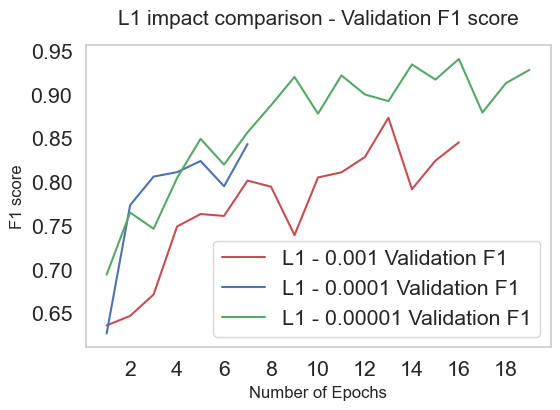

<Figure size 600x400 with 0 Axes>

In [ ]:
plot_history(historyBW_aug_l1,historyBW_aug_l1_4,historyBW_aug_l1_5, 3,'L1 - 0.001','L1 - 0.0001', 'L1 - 0.00001')

# Best Model

In [ ]:
best_model = modelBW_aug_4

### Grid with predictions

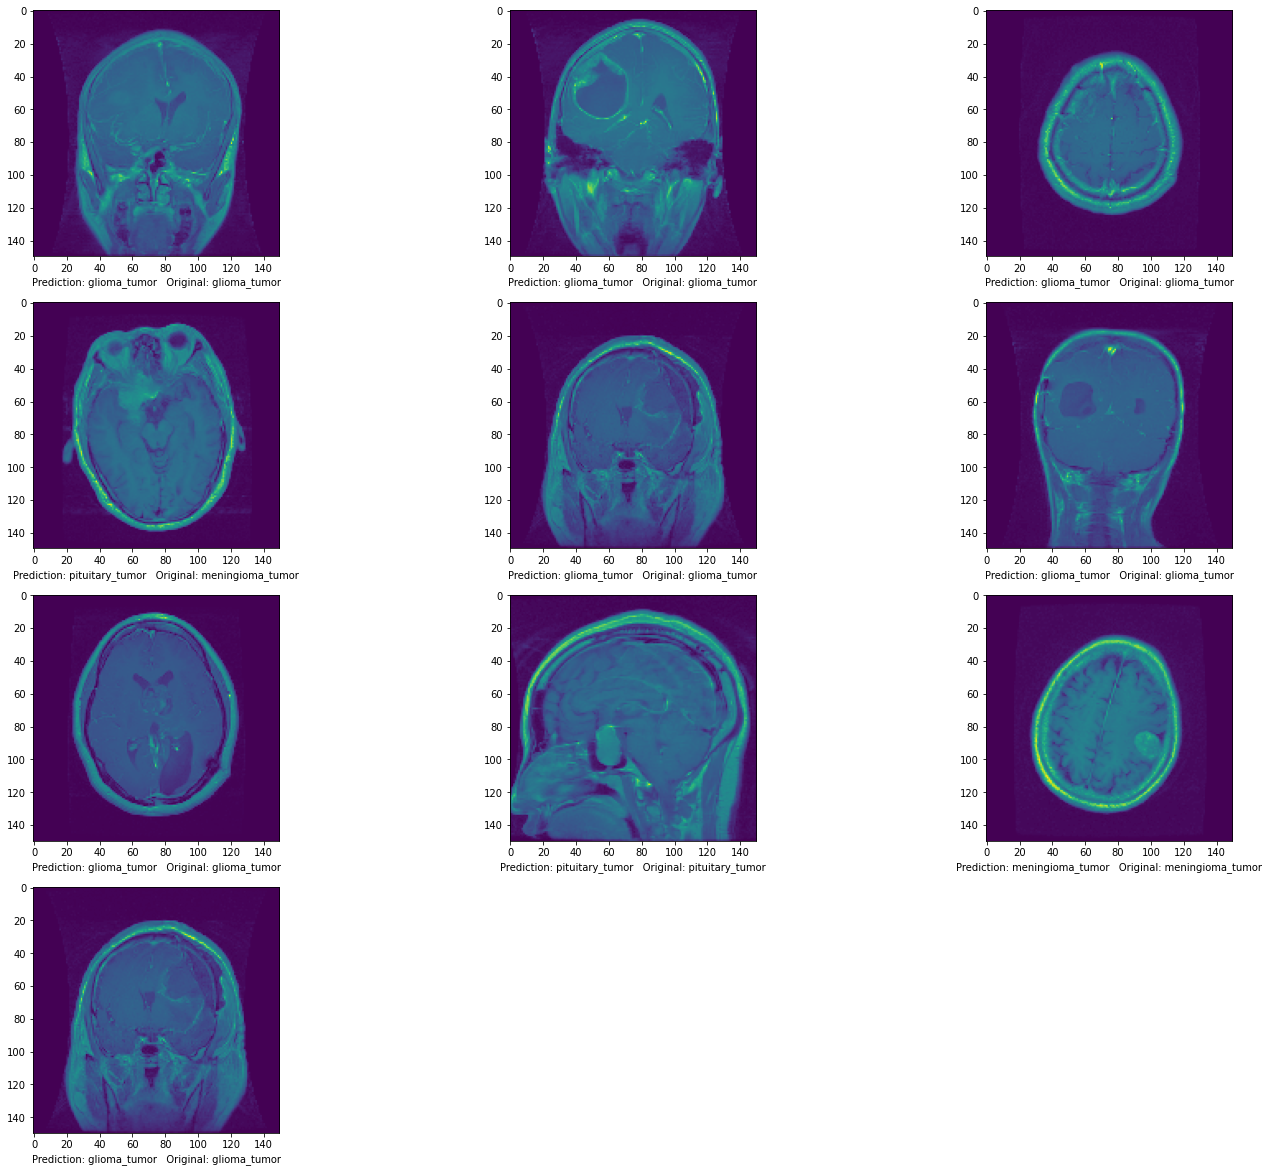

In [ ]:
prediction = []
original = []
image = []
count = 0
for i in os.listdir('./tumor_data/test/'):
  for item in os.listdir(os.path.join('./tumor_data/test', i)):
    # code to open the image
    img = keras.preprocessing.image.load_img(os.path.join('./tumor_data/test', i, item), color_mode = 'grayscale', target_size = (150,150))
    x = keras.preprocessing.image.img_to_array(img)
    #append to image list
    image.append(x)
    #expand dimension
    img = np.expand_dims(img, axis=0)
    img = img/255
    #predict
    predict = best_model.predict(img)
    #get the index corresponding to the highest value in the prediction
    predict = np.argmax(predict)
    #append the predicted class to the list
    prediction.append(class_dict[predict])
    #append original class to the list
    if i == 'test_1':
      original.append('meningioma_tumor')
    if i == 'test_2':
      original.append('glioma_tumor')
    if i == 'test_3':
      original.append('pituitary_tumor')

#visualize the results
import random
fig = plt.figure(figsize = (20, 20))
for i in range(10):
    j = random.randint(0, len(image))
    fig.add_subplot(5, 3, i+1)
    plt.xlabel("Prediction: " + prediction[j] +"   Original: " + original[j])
    plt.imshow(image[j])
fig.tight_layout()
plt.show()

# Transfer Learning

# Feature Extraction

In [24]:
train_generator_aug_feat = train_datagen_aug.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=1,
    class_mode='categorical',
    color_mode='grayscale',
    seed=42,
    shuffle = False
)

val_generator_feat = val_datagen.flow_from_directory(
    val_path,
    target_size=(150, 150),
    batch_size=1,
    class_mode='categorical',
    color_mode='grayscale',
    seed=42,
    shuffle = False
)

test_generator_feat = test_datagen.flow_from_directory(
    test_path,
    target_size=(150, 150),
    batch_size=1,
    class_mode='categorical',
    color_mode='grayscale',
    seed=42,
    shuffle=False
)

Found 2451 images belonging to 3 classes.
Found 307 images belonging to 3 classes.
Found 306 images belonging to 3 classes.


In [25]:
def metrics(y_train, pred_train , y_val, pred_val):
    print('___________________________________________________________________________________________________________')
    print('                                                     TRAIN                                                 ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_train, pred_train))
    print('Confusion Matrix:')
    print(confusion_matrix(y_train, pred_train))


    print('___________________________________________________________________________________________________________')
    print('                                                VALIDATION                                                 ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_val, pred_val))
    print('Confusion Matrix:')
    print(confusion_matrix(y_val, pred_val))
    
    print('F1 Train: '+str(f1_score(y_train, pred_train, average = 'macro')))
    print('F1 Val: '+str(f1_score(y_val, pred_val, average = 'macro')))

    return f1_score(y_train, pred_train, average = 'macro'), f1_score(y_val, pred_val, average = 'macro')

## Our Model

In [26]:
best_model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_56 (Conv2D)           (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 34, 34, 64)        36928     
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 17, 17, 64)        0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 18496)           

In [27]:
feature_extraction = models.Sequential()

for layer in best_model.layers[:-3]:
    feature_extraction.add(layer)

In [28]:
#Extraction of features

predict_train = feature_extraction.predict(train_generator_aug_feat,2451)
predict_val = feature_extraction.predict(val_generator_feat,307)
predict_test = feature_extraction.predict(test_generator_feat,306)

In [29]:
# Creating csv files
df = pd.DataFrame()
"""
    If the file already exists delete its content 
    (otherwise we have repeated data everytime we run the file)
    
    Else create the csv - for training, validation and test
"""
# Train file
if os.path.exists(r'.\train_csv.csv'):
    f = open(r'.\train_csv.csv', "w+")
    f.close()
else:
    df.to_csv(r'.\train_csv.csv')

# Validation file
if os.path.exists(r'.\val_csv.csv'):
    f = open(r'.\val_csv.csv', "w+")
    f.close()
else:
    df.to_csv(r'.\val_csv.csv')

# Test file
if os.path.exists(r'.\test_csv.csv'):
    f = open(r'.\test_csv.csv', "w+")
    f.close()
else:
    df.to_csv(r'.\test_csv.csv')

In [30]:
train_csv = open('train_csv.csv', 'w')
val_csv = open('val_csv.csv', 'w')
test_csv = open('test_csv.csv', 'w')

In [31]:
for (label, vec) in zip(train_generator_aug.classes, predict_train):
			# construct a row that exists of the class label and
			# extracted features
			vec = ",".join([str(v) for v in vec])
			train_csv.write("{},{}\n".format(label, vec))
   
train_csv.close()

for (label, vec) in zip(val_generator.classes, predict_val):
			# construct a row that exists of the class label and
			# extracted features
			vec = ",".join([str(v) for v in vec])
			val_csv.write("{},{}\n".format(label, vec))
   
val_csv.close()

for (label, vec) in zip(test_generator.classes, predict_test):
			# construct a row that exists of t
			# he class label and
			# extracted features
			vec = ",".join([str(v) for v in vec])
			test_csv.write("{},{}\n".format(label, vec))
   
test_csv.close()

In [32]:
# Defining train, validation and test datasets
df_train = pd.read_csv('train_csv.csv', header = None)
df_val = pd.read_csv('val_csv.csv', header = None)
df_test = pd.read_csv('test_csv.csv', header = None)

In [33]:
# Shuffle the rows in dataframes so that all the labels are shuffled

train_dataframe = df_train.sample(frac = 1).reset_index(drop = True)
val_dataframe = df_val.sample(frac=1).reset_index(drop=True)
test_dataframe = df_test.sample(frac=1).reset_index(drop=True)

In [34]:
# Split dataframes in features - X - and labels - y

# Train dataset
X_train = train_dataframe.drop(columns = 0)
y_train = train_dataframe[0]

# Validation dataset
X_val = val_dataframe.drop(columns = 0)
y_val = val_dataframe[0]

# Test dataset
X_test = test_dataframe.drop(columns = 0)
y_test = test_dataframe[0]

##### Adaboost

In [35]:
Adaboost_model = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth=1), learning_rate = 0.2, algorithm = 'SAMME.R', n_estimators = 100, random_state = 42)
Adaboost_model.fit(X_train, y_train)
metrics(y_train, Adaboost_model.predict(X_train) , y_val, Adaboost_model.predict(X_val))

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.76      0.58      0.66       566
           1       0.83      0.92      0.88      1141
           2       0.96      0.97      0.96       744

    accuracy                           0.86      2451
   macro avg       0.85      0.82      0.83      2451
weighted avg       0.85      0.86      0.85      2451

Confusion Matrix:
[[ 329  209   28]
 [  84 1053    4]
 [  20    2  722]]
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
------

(0.8327620900829623, 0.8171348478767269)

In [ ]:
Adaboost_model = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth=1), learning_rate = 0.2, algorithm = 'SAMME.R', n_estimators = 50, random_state = 42)
Adaboost_model.fit(X_train, y_train)
metrics(y_train, Adaboost_model.predict(X_train) , y_val, Adaboost_model.predict(X_val))

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.72      0.47      0.57       566
           1       0.79      0.91      0.85      1141
           2       0.92      0.95      0.93       744

    accuracy                           0.82      2451
   macro avg       0.81      0.78      0.78      2451
weighted avg       0.81      0.82      0.81      2451

Confusion Matrix:
[[ 265  261   40]
 [  82 1039   20]
 [  22   17  705]]
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
------

(0.7822137748112937, 0.7665833522684239)

##### Random Forest

In [ ]:
RF_model = RandomForestClassifier(max_features = 'sqrt', random_state = 42, n_estimators = 100, min_samples_leaf=100)

RF_model.fit(X_train, y_train)

metrics(y_train, RF_model.predict(X_train) , y_val, RF_model.predict(X_val))

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.77      0.53      0.63       566
           1       0.79      0.85      0.82      1141
           2       0.81      0.91      0.86       744

    accuracy                           0.80      2451
   macro avg       0.79      0.77      0.77      2451
weighted avg       0.79      0.80      0.79      2451

Confusion Matrix:
[[302 192  72]
 [ 83 973  85]
 [  5  62 677]]
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
---------------

(0.7705459553170427, 0.7143547273982057)

##### K-Nearest Neighbors

In [ ]:
knn =KNeighborsClassifier(algorithm='kd_tree',leaf_size=20,n_neighbors=6)
knn.fit(X_train, y_train)
metrics(y_train, knn.predict(X_train) , y_val, knn.predict(X_val))

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.81      0.87       566
           1       0.91      0.97      0.94      1141
           2       0.98      0.97      0.97       744

    accuracy                           0.93      2451
   macro avg       0.94      0.92      0.93      2451
weighted avg       0.93      0.93      0.93      2451

Confusion Matrix:
[[ 461   91   14]
 [  33 1106    2]
 [   4   21  719]]
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
------

(0.9255017933077218, 0.8428322989557321)

### One vs Rest

In [ ]:
svm_model = OneVsRestClassifier(SVC(kernel="rbf", C=10))
svm_model.fit(X_train, y_train)
metrics(y_train, svm_model.predict(X_train),y_val, svm_model.predict(X_val))

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       566
           1       1.00      1.00      1.00      1141
           2       1.00      1.00      1.00       744

    accuracy                           1.00      2451
   macro avg       1.00      1.00      1.00      2451
weighted avg       1.00      1.00      1.00      2451

Confusion Matrix:
[[ 566    0    0]
 [   0 1141    0]
 [   0    0  744]]
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
------

(1.0, 0.9383140619037024)

## Pre-trained models

In [ ]:
# Based on https://www.kaggle.com/code/darthmanav/densenet-121-feature-extraction/notebook

## RGB

In [ ]:
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(150,150,3))

In [ ]:
base_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_4 (ZeroPadding2D (None, 156, 156, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 75, 75, 64)   9408        zero_padding2d_4[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [ ]:
base_model.trainable = False

In [ ]:
callbacks_testepretrained = callback("\model_testepretrained.h5")

In [ ]:
x = base_model.output
#x = GlobalAveragePooling2D()(x) ########
x =  Dropout(0.5)(x)
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(1024,kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x =  Dropout(0.5)(x)
x = Dense(1024,kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x =  Dropout(0.5)(x)
x = Dense(1024,kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x =  Dropout(0.5)(x)

predictions = Dense(3,activation='softmax')(x)

model_testepretrained = Model(inputs=base_model.input,outputs=predictions)

In [ ]:
model_testepretrained.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = [f1_m]) 
history_testepretrained = model_testepretrained.fit_generator(train_generator_rgb, callbacks = callbacks_testepretrained, epochs = 30, steps_per_epoch = 123, validation_steps = 16,
                                 validation_data = val_generator_rgb, workers = 2)

Epoch 1/30
123/123 [==============================] - ETA: 0s - loss: 0.7122 - f1_m: 0.7426
Epoch 00001: val_loss improved from inf to 0.46709, saving model to c:\Users\beatr\OneDrive - NOVAIMS\2nd semester\Deep Learning\DeepLearning_Group_Project\models\model_testepretrained.h5
123/123 [==============================] - 241s 2s/step - loss: 0.7122 - f1_m: 0.7426 - val_loss: 0.4671 - val_f1_m: 0.8549
Epoch 2/30
123/123 [==============================] - ETA: 0s - loss: 0.4666 - f1_m: 0.8335
Epoch 00002: val_loss improved from 0.46709 to 0.22334, saving model to c:\Users\beatr\OneDrive - NOVAIMS\2nd semester\Deep Learning\DeepLearning_Group_Project\models\model_testepretrained.h5
123/123 [==============================] - 231s 2s/step - loss: 0.4666 - f1_m: 0.8335 - val_loss: 0.2233 - val_f1_m: 0.9087
Epoch 3/30
123/123 [==============================] - ETA: 0s - loss: 0.3623 - f1_m: 0.8765
Epoch 00003: val_loss did not improve from 0.22334
123/123 [==============================] - 22

In [ ]:
#np.save('models/historyPT.npy',history_testepretrained.history)
model_testepretrained = keras.models.load_model('models/model_testepretrained.h5', custom_objects=dependencies)
historyPT=np.load('models/historyPT.npy',allow_pickle='TRUE').item()
#timesPT= time_callback.times
#save_times(model_testepretrained, timesPT,'model_testepretrained')


In [ ]:
#OUTRO 2
#https://medium.com/analytics-vidhya/cnn-transfer-learning-with-vgg-16-and-resnet-50-feature-extraction-for-image-retrieval-with-keras-53320c580853

In [171]:
vgg_model = VGG16(weights='imagenet', input_shape=(150,150,3), include_top=False)

In [172]:
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [173]:
vgg_model.trainable = False

In [174]:
callbacks_vgg_model = callback("\model_vgg_model.h5")

In [181]:
 # Add fully connected layer which have 1024 neuron to VGG-16 model
output = vgg_model.output 
output  = Flatten()(output)
output  = Dense(units=1024, activation='relu')(output )
predictions = Dense(units=3, activation='softmax')(output )


vgg_model = Model(vgg_model.input, outputs=predictions)


In [182]:
# Compile VGG-16 model
vgg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[f1_m])

history_vgg_model= vgg_model.fit_generator(train_generator_rgb, callbacks = callbacks_vgg_model, epochs = 30, steps_per_epoch = 123, validation_steps = 16,
                                 validation_data = val_generator_rgb, workers = 2)

Epoch 1/30
123/123 [==============================] - ETA: 0s - loss: 0.6670 - f1_m: 0.7749
Epoch 00001: val_loss improved from inf to 0.37161, saving model to c:\Users\beatr\OneDrive - NOVAIMS\2nd semester\Deep Learning\DeepLearning_Group_Project\models\model_vgg_model.h5
123/123 [==============================] - 514s 4s/step - loss: 0.6670 - f1_m: 0.7749 - val_loss: 0.3716 - val_f1_m: 0.8467
Epoch 2/30
123/123 [==============================] - ETA: 0s - loss: 0.2583 - f1_m: 0.8939
Epoch 00002: val_loss improved from 0.37161 to 0.29516, saving model to c:\Users\beatr\OneDrive - NOVAIMS\2nd semester\Deep Learning\DeepLearning_Group_Project\models\model_vgg_model.h5
123/123 [==============================] - 512s 4s/step - loss: 0.2583 - f1_m: 0.8939 - val_loss: 0.2952 - val_f1_m: 0.8938
Epoch 3/30
123/123 [==============================] - ETA: 0s - loss: 0.2210 - f1_m: 0.9114
Epoch 00003: val_loss improved from 0.29516 to 0.26819, saving model to c:\Users\beatr\OneDrive - NOVAIMS\2n

In [ ]:
#np.save('models/historyPT_VGG.npy',history_vgg_model.history)
model_vgg_model = keras.models.load_model('models/model_vgg_model.h5', custom_objects=dependencies)
historyPT_VGG=np.load('models/historyPT_VGG.npy',allow_pickle='TRUE').item()
#timesVGG= time_callback.times
#save_times(model_vgg_model, timesVGG,'model_vgg_model')

## Grad-CAM

In [ ]:
def array_picture(img_path, size):
    img = keras.preprocessing.image.load_img(img_path, target_size=size, color_mode = "grayscale")
    array = keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)

    # Normalizing the pixeis
    array = array / 255
    
    return array

def make_gradcam(img_array, model, last_conv_layer_name, pred_index=None):
    # Model that maps input image to activations of the last layer
    # Plus output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Gradient of top predicted class for input image
    # with respect to activations of last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Gradient of output neuron (top predicted)
    # with regard to output feature map of last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Vector where each entry is mean intensity of gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Each channel in the feature map array multiplied
    # by "how important this channel is" with regard to top predicted class
    # Sum all the channels to obtain heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, normalize heatmap between [0,1]
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

Predictions: [[10.521693   5.8704467 -8.862395 ]]


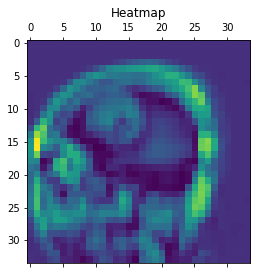

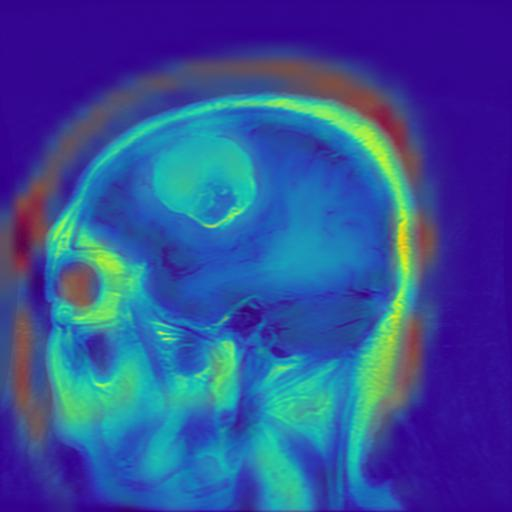

In [ ]:
# Choosing picture and resizing it
img_path = './tumor_data/test/test_1/1_179.png'
size = (150,150)
img_array = array_picture(img_path = img_path, size = size)

# Remove softmax
best_model.layers[-1].activation = None

# Last Convolutional Layer
last_conv_layer_name = 'conv2d_58'

# Predictions
preds = best_model.predict(img_array)
print(f'Predictions: {preds}')

# Heatmap
heatmap = make_gradcam(img_array, best_model, last_conv_layer_name, pred_index = 0)

# Display heatmap
plt.matshow(heatmap)
plt.title('Heatmap')
plt.show()

# Display Heatmap with original picture
display_gradcam(img_path, heatmap)

In [ ]:
list_wrong_1 = []
for file in os.listdir('./tumor_data/test/test_1'):
    filename = os.fsdecode(file)
    img = keras.preprocessing.image.load_img(os.path.join('./tumor_data/test/test_1', filename), color_mode = 'grayscale', target_size = (150,150))
    x = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img/255
    #predict
    predict = best_model.predict(img)
    predict = np.argmax(predict)
    predict = class_dict[predict]
    if predict != 'meningioma_tumor':
        list_wrong_1.append(file)

In [ ]:
list_wrong_1

['1_351.png', '1_493.png', '1_586.png', '1_692.png', '1_705.png', '1_92.png']

In [ ]:
list_wrong_2 = []
for file in os.listdir('./tumor_data/test/test_2'):
    filename = os.fsdecode(file)
    img = keras.preprocessing.image.load_img(os.path.join('./tumor_data/test/test_2', filename), color_mode = 'grayscale', target_size = (150,150))
    x = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img/255
    #predict
    predict = best_model.predict(img)
    predict = np.argmax(predict)
    predict = class_dict[predict]
    if predict != 'glioma_tumor':
        list_wrong_2.append(file)

In [ ]:
list_wrong_2

['2_128.png',
 '2_347.png',
 '2_465.png',
 '2_488.png',
 '2_495.png',
 '2_496.png',
 '2_662.png']

In [ ]:
list_wrong_3 = []
for file in os.listdir('./tumor_data/test/test_3'):
    filename = os.fsdecode(file)
    img = keras.preprocessing.image.load_img(os.path.join('./tumor_data/test/test_3', filename), color_mode = 'grayscale', target_size = (150,150))
    x = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img/255
    #predict
    predict = best_model.predict(img)
    predict = np.argmax(predict)
    predict = class_dict[predict]
    if predict != 'pituitary_tumor':
        list_wrong_3.append(file)

In [ ]:
list_wrong_3

['3_919.png']

Prediction: meningioma_tumor   Original: meningioma_tumor


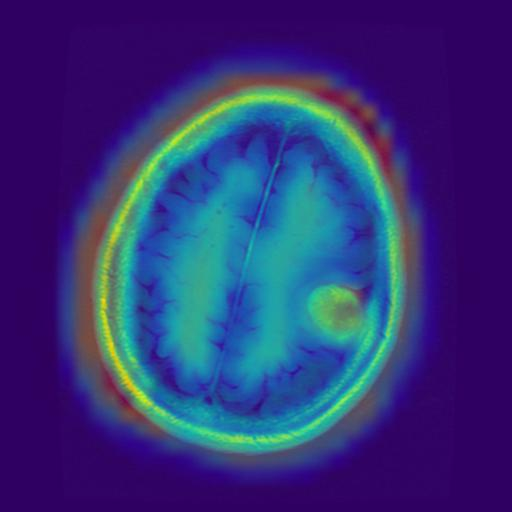

In [ ]:
# code to open the image
folder = 'test_1'
img_path = './tumor_data/test/test_1/1_453.png'
size = (150, 150)
img_array = array_picture(img_path = img_path, size = size)
# Remove softmax
best_model.layers[-1].activation = None
# Last Convolutional Layer
last_conv_layer_name = 'conv2d_58'
#predict
predict = best_model.predict(img_array)
#get the index corresponding to the highest value in the prediction
predict = np.argmax(predict)
#append the predicted class to the list
predict = list(class_dict.values())[predict]
heatmap = make_gradcam(img_array, best_model, last_conv_layer_name, pred_index = 0)

#append original class to the list
if folder == 'test_1':
  original = 'meningioma_tumor'
if folder == 'test_2':
  original = 'glioma_tumor'
if folder == 'test_3':
  original = 'pituitary_tumor'

#visualize the results

print("Prediction: " + str(predict) +"   Original: " + str(original))
image = display_gradcam(img_path, heatmap)
